In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from utilities import show_heat_map, reduce_array


In [2]:
def dct_basis(n,k1,k2):
    x = np.array([range(n)])
    x = 2*np.cos(np.pi*(2*x+1)*k1/2.0/n)
    red1 = 1/np.sqrt(2) if k1==0 else 1

    y = np.array([range(n)])
    y = 2*np.cos(np.pi*(2*y+1)*k2/2.0/n)
    red2 = 1/np.sqrt(2) if k2==0 else 1
    
    return np.dot(x.T,y)*red1*red2/2/n

def curve_score(Targx, Targy, Testx, Testy):
    '''custom score that measures how low is Test compared to Target'''
    sc=0
    for x,y in zip(Testx,Testy):
        if x<Targx[0]: # x>Testx
            sc+= 0
        elif x >= Targx[-1]:
            sc += 0
        else:
            ind = [e>x for e in Targx].index(1)
            if ind<=0:
                print(ind) 
            d = (Targy[ind-1]+Targy[ind])/2-y   
            if (d>0):         
                sc = max(sc, d)
    return sc/max(Targy)

def load_tensor_img(str):
    im = np.array(Image.open(str))
    im = np.array(im).mean(axis=2) # convert to bw
    im = torch.FloatTensor(im)
    return im

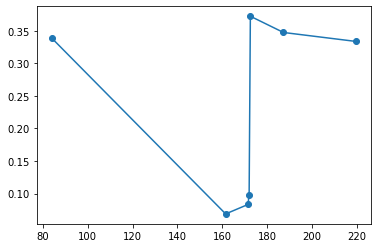

In [56]:
class DCT_CONV(nn.Module):
    def __init__(self, ksize=8, T=36):
        ''' k: kernel size
            T: number of first coefficients used'''
        super(__class__, self).__init__()

        dtype = torch.FloatTensor
        if torch.cuda.is_available():  dtype = torch.cuda.FloatTensor
        self.ksize=ksize
        ch = ksize**2

        self.T = T

        self.padding = nn.ReflectionPad2d(2*ksize//2-1)

        self.conv_in = nn.Conv2d(in_channels=1, out_channels= ch,
                                    kernel_size=ksize, stride=1,
                                    padding=0, bias=False)

        indices = [(i%ksize,i//ksize) for i in range(ch)]
        indices.sort(key=lambda e: e[0]+e[1])
        for ind,i in zip(indices,range(ch)):         
            a1 = dct_basis(ksize,ind[0],ind[1])
            self.conv_in.weight.data[i,0,:,:] = nn.Parameter(dtype(a1))

    def forward(self, x):
        out = self.conv_in(self.padding(x[None,None,:,:]))
        return out[0]

    def mean_dct(self, output):
        '''mean of the output'''
        return output[0, :, :]/self.ksize

    def lowfreq_var(self,output):
        '''low_frequency variance'''
        low_freq = output[1:self.T, :, :]**2 # exclude mean
        low_freq = torch.sum(low_freq,dim=0)/(self.T-1)
        return low_freq

    def noise_var(self, output, mean_dct, lowfreq_var, low_val, high_val, f_var=0.01):
        '''returns relevant noise variance when image value is between low_val and high_val
            f_var: fractions used to estimate noise'''
        # select image values between low_val and high_val
        mean_mask = (mean_dct<high_val)*(mean_dct>=low_val) 

        # Select small low_frequency variances (~uniform patches)
        lowf_variances = torch.masked_select(lowfreq_var, mean_mask) 
        if lowf_variances.size()[0]==0:
            return torch.tensor([]),torch.tensor([])
        tresh = torch.quantile(lowf_variances,f_var)
        lowf_mask = (lowfreq_var<tresh)*mean_mask

        # mask the corresponding pixels
        high_freq = (output[self.T:]*lowf_mask)**2
        high_freq = torch.sum(high_freq, dim=(1,2))/torch.sum(lowf_mask) # mean of the variances [ksize**2 - T] vector
        return torch.median(high_freq)

    def image_variance_hist(self, x, e_per_bin=40000, f_var=0.01):
        ''' input: [H,W] tensor
            output: variance histogram'''

        # compute DCT transforms, dim [ksize**2, H, W]
        output = self.forward(x)

        # compute image mean values 
        mean_dct = self.mean_dct(output) # dim [H, W]
        mean_list = mean_dct.flatten().sort()[0]

        # compute lowfreq_var
        lowfreq_var = self.lowfreq_var(output) # dim [H, W]

        Lmeans=[]
        Lvars=[]
        if e_per_bin<len(mean_list):
            for index in range(0, len(mean_list), e_per_bin):
                low_val = mean_list[index]
                high_val = mean_list[min(index+e_per_bin,len(mean_list)-1)]
                Lmeans.append( (high_val+low_val).item()/2)
                Lvars.append(self.noise_var(output,mean_dct, lowfreq_var,low_val,high_val, f_var).item())
        return Lmeans,Lvars
        

    def show_net(self):
        out_img = np.zeros((self.ksize**2,self.ksize**2))
        for i in range(self.ksize**2):
            x = i//self.ksize
            y = i%self.ksize
            out_img[x*self.ksize:(x+1)*self.ksize,y*self.ksize:(y+1)*self.ksize]=self.conv_in.weight.data[i,0,:,:] 
        plt.imshow(out_img)
        plt.show()

%matplotlib inline

M = DCT_CONV(ksize=8)
# M.show_net()
im = load_tensor_img("forged_images/cyg.png")

Lm,Lv= M.image_variance_hist(im, e_per_bin=40000, f_var=0.005)
plt.plot(Lm,Lv,'o-')

438 584
0 % done
20 % done
41 % done
61 % done
82 % done


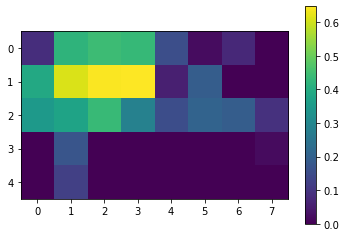

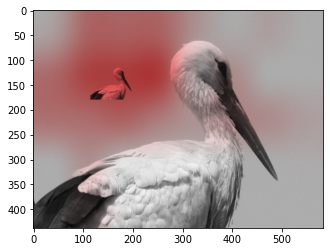

In [119]:
%matplotlib inline
im = load_tensor_img("forged_images/cyg.png")

Lm,Lv= M.image_variance_hist(im, e_per_bin=40000, f_var=0.005)
# Lv = [e if e<1 else 0 for e in Lv]
# plt.plot(Lm,Lv,'o-')

patch_size= 128
step = patch_size//2
n,m = im.shape
print(n,m)
new_n =len(range(0,n-patch_size,step))
new_m =len(range(0,m-patch_size,step))
percent_wrong = np.zeros((new_n,new_m))
mean_red = np.zeros((new_n,new_m))

for i in range(0,n-patch_size,step):
    print( int(100*i/(n-patch_size)), "% done" )
    for j in range(0,m-patch_size, step):
        Lm2,Lv2= M.image_variance_hist(im[i:i+patch_size,j:j+patch_size], e_per_bin=10000, f_var=0.005)
        percent_wrong[i//step,j//step]=curve_score(Lm,Lv,Lm2,Lv2)
        mean_red[i//step,j//step] = im[i:i+patch_size,j:j+patch_size].mean()

# plt.plot(Lm2,Lv2,'o-')

plt.imshow(percent_wrong)
plt.colorbar()
plt.show()
plt.imshow(show_heat_map(im,percent_wrong))
plt.show()

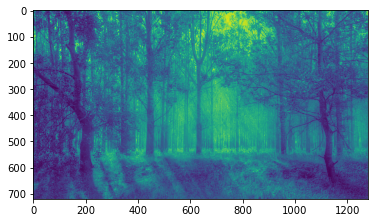

In [120]:
# im=load_tensor_img("forged_images/forest_rhino.jpg")
im=load_tensor_img("paysages/forest.jpg")


out = M(im)
plt.imshow(im)
arr = (out[36:]**2).mean(dim=0).detach()



0


/var/folders/b0/vdqv_k0s1w73jvkrsk0kfb7c0000gn/T/ipykernel_6104/1089597685.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.masked_select(torch.tensor(arr), torch.tensor(mask))


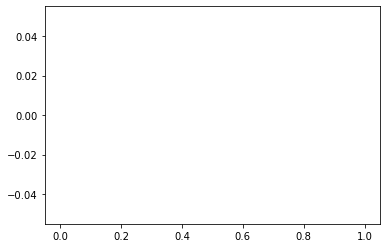

10


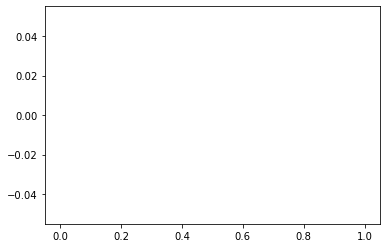

20


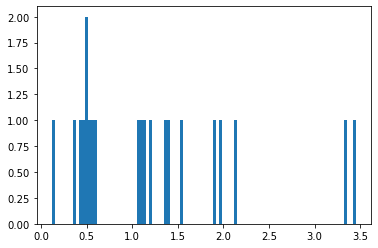

30


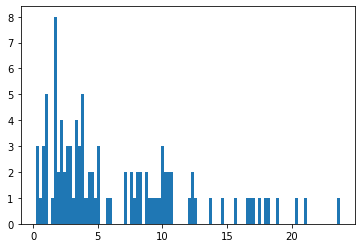

40


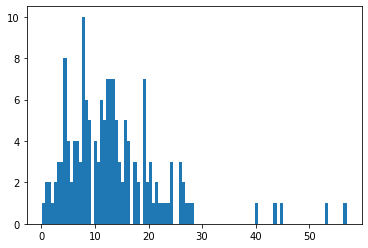

50


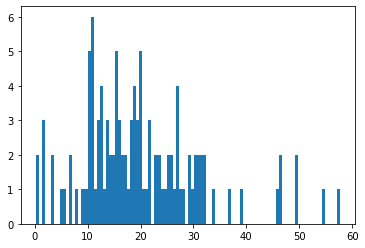

60


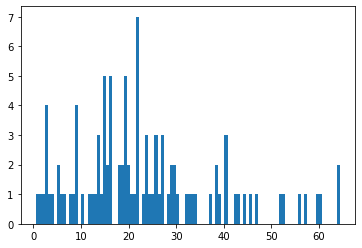

70


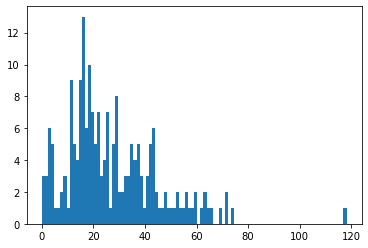

80


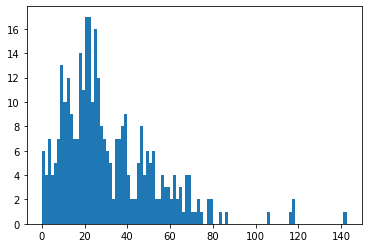

90


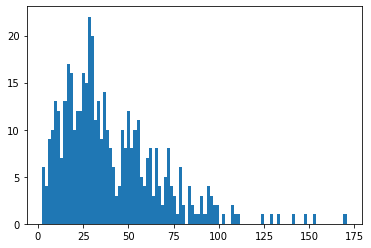

100


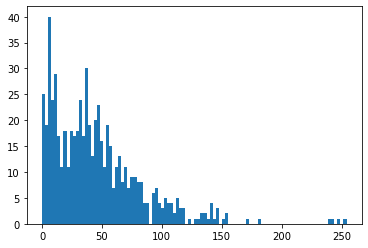

110


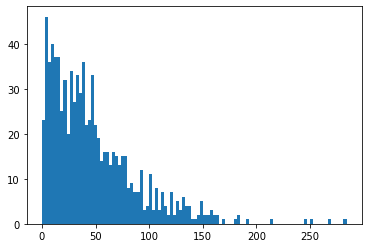

120


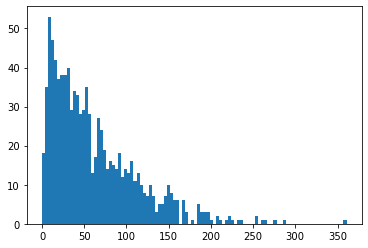

130


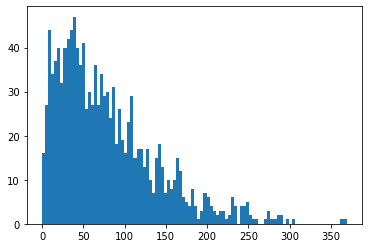

140


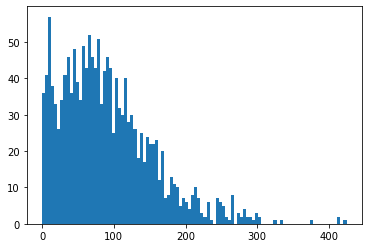

150


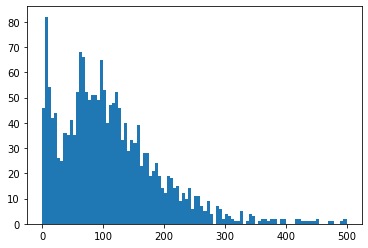

160


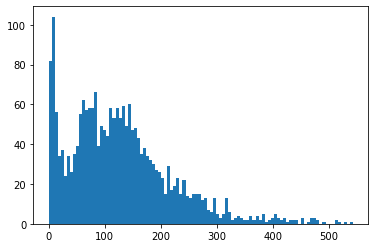

170


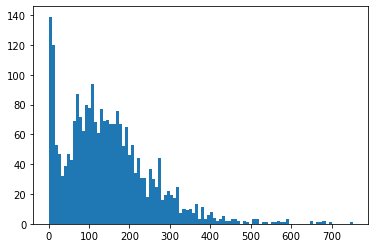

180


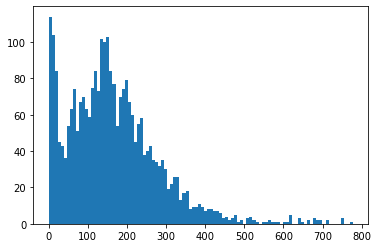

190


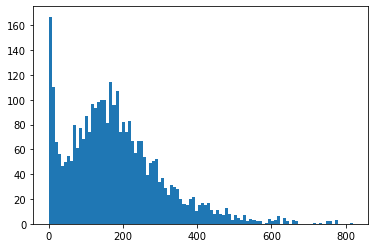

200


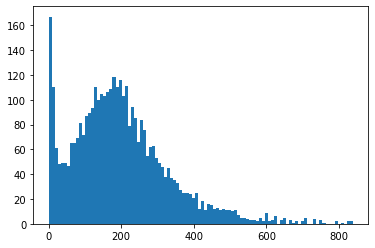

210


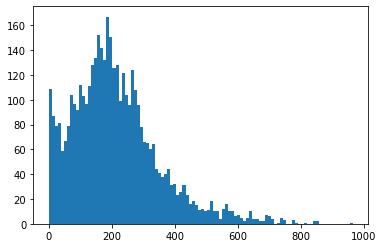

220


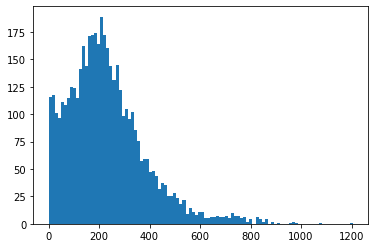

230


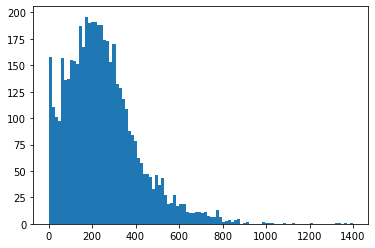

240


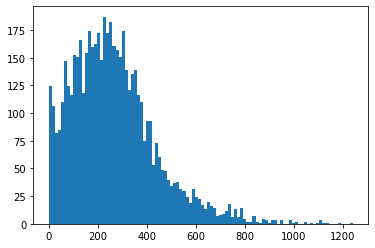

250


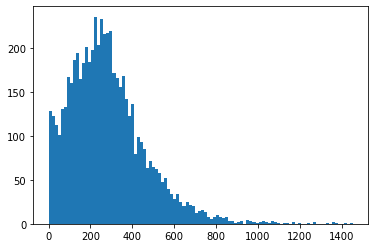

In [122]:

%matplotlib inline
arr = (out[36:]**2).mean(dim=0).detach()

step=10

means=[]

for i in range(0,255,step):
    mask = (out[0]>i)*(out[0]<i+step)
    print(i)
    values = torch.masked_select(torch.tensor(arr), torch.tensor(mask))
    means.append(values.mean())
    plt.hist(values.tolist(),bins=100)
    plt.show()

values = range(0,255,step)


/var/folders/b0/vdqv_k0s1w73jvkrsk0kfb7c0000gn/T/ipykernel_6104/565562954.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(values,np.log(means)/np.sqrt(values))


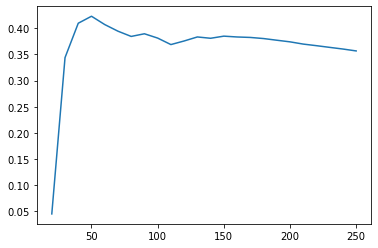

In [127]:
values=np.array(values)
plt.plot(values,np.log(means)/np.sqrt(values))


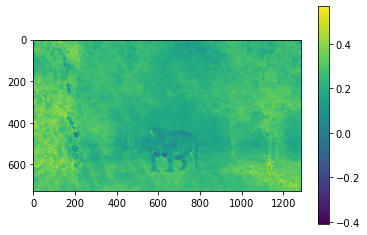

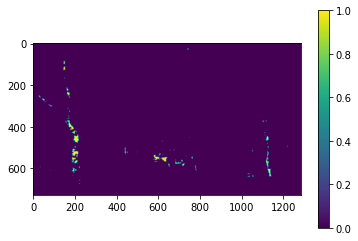

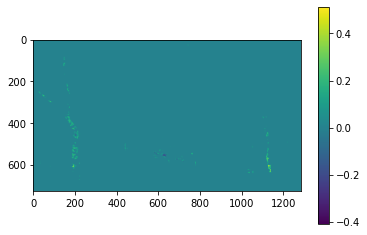

In [128]:
im = load_tensor_img("forged_images/forest_rhino.jpg")
out = M(im)
lowf = M.lowfreq_var(out)
arr = (out[36:]**2).mean(dim=0)
# arr = reduce_array(arr,4,np.mean)
# arr = reduce_array(arr,4,np.mean)

normalization = (torch.log(arr)/torch.sqrt(out[0])).detach()
# normalization = reduce_array(normalization,4,np.mean)
# normalization = reduce_array(normalization,4,np.mean)
plt.imshow(normalization)
plt.colorbar()
plt.show()
plt.imshow(-torch.log(lowf).detach()>-4)
plt.colorbar()
plt.show()
plt.imshow(normalization*(-torch.log(lowf).detach()>-4))
plt.colorbar()
plt.show()

